In [21]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tifffile as tiff
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [22]:
with open('../data/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [23]:
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [24]:
def make_seg_mask_class1(tiles_dict):
    mask = np.zeros((512, 512), dtype=np.float32)
    for annot in tiles_dict['annotations']:
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cd in cords:
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                mask[rr, cc] = 1
                
    contours,_ = cv2.findContours((mask*255).astype(np.uint8), 1, 2)
    zero_img = np.zeros([mask.shape[0], mask.shape[1]], dtype="uint8")

    for p in contours:
        cv2.fillPoly(zero_img, [p], (255, 255))
    # zero_img = cv2.blur(zero_img, (6, 6))
    return zero_img    

In [25]:
blood_vessel_class = []
glomerulus_class = []
unsure_class = []

In [26]:
def make_seg_mask_class3(tiles_dict):
    # green channel encodes instances [:,:,1] 
    # red channel encodes semantic category [:,:,0] 
    mask = np.zeros((512, 512,3), dtype=np.uint8)
    c1 = False
    c2 = False
    c3 = False
    for annot in tiles_dict['annotations']:
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cd in cords:
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                mask[:,:,0][rr, cc] = 1
                mask[:,:,1][rr, cc] = 1
            c1 = True
        elif annot['type'] == "glomerulus":
            for cd in cords:
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                mask[:,:,0][rr, cc] = 1
                mask[:,:,1][rr, cc] = 2
            c2 = True
        elif annot['type'] == "unsure":
            for cd in cords:
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                mask[:,:,0][rr, cc] = 1
                mask[:,:,1][rr, cc] = 3
            c3 = True
    if c1:
        blood_vessel_class.append(1)
    else:
        blood_vessel_class.append(0)
    if c2:
        glomerulus_class.append(1)
    else:
        glomerulus_class.append(0)
    if c3:
        unsure_class.append(1)
    else:
        unsure_class.append(0)
                
    return mask    

In [27]:
all_ids = []

In [28]:
os.makedirs('../data/train_images_class3', exist_ok=True)
os.makedirs('../data/train_masks_class3', exist_ok=True)

for i, tldc in enumerate(tqdm(tiles_dicts)):
    array = tiff.imread(f'../data/train/{tldc["id"]}.tif')
    img_example = Image.fromarray(array)
    img = np.array(img_example)
    mask = make_seg_mask_class3(tldc)
    # plt.imshow(mask)
    # break
    
    if np.sum(mask)>0:
        cv2.imwrite(f'../data/train_images_class3/{tldc["id"]}.png', img)
        np.save(f'../data/train_masks_class3/{tldc["id"]}.npy', mask)
        # cv2.imwrite(f'../data/mask_images_class3/{tldc["id"]}.png', mask)
        all_ids.append({tldc["id"]}.pop())
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1633/1633 [00:20<00:00, 78.00it/s]


In [29]:
import pandas as pd

In [30]:
df = pd.DataFrame()

In [31]:
print(len(all_ids))
print(len(blood_vessel_class))
print(len(glomerulus_class))

1633
1633
1633


In [32]:
df["id"] = all_ids
df["blood_vessel"] = blood_vessel_class
df["glomerulus"] = glomerulus_class
df["unsure_class"] = unsure_class

In [33]:
df.to_csv("../data/train_class3.csv",index = False)

In [34]:
import cv2

In [35]:
mask_a = np.load("../data/train_masks_class3/016c33dacfa1.npy")

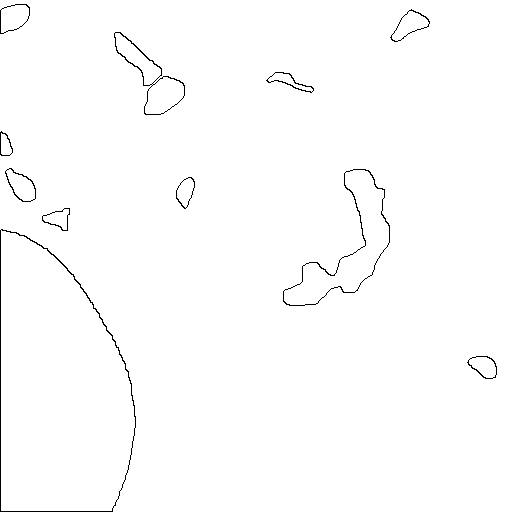

In [42]:
import matplotlib.pyplot as plt
# let's visualize the first instance (ignoring background)

instance_seg = mask_a[:,:,1] # green channel encodes instances
class_id_map = mask_a[:,:,0] # red channel encodes semantic category
class_labels = np.unique(class_id_map)
# let's visualize the first instance (ignoring background)
mask = (instance_seg == 0)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

In [37]:
np.unique(instance_seg)

array([0, 1, 2], dtype=uint8)

In [43]:
# create mapping between instance IDs and semantic category IDs
inst2class = {}
for label in class_labels:
    instance_ids = np.unique(instance_seg[class_id_map == label])
    inst2class.update({i: label for i in instance_ids})
print(inst2class)

{0: 0, 1: 1, 2: 1}
